# Cross-epoch geometry distance and behavioral correlations

For each task, compute tuning curves in cue, delay and response epochs.
Group neurons by monkey × age. Build PCA representations per epoch.
Compute Procrustes distance between delay–cue and delay–response per monkey–age pair.
Correlate with DI and RT.

In [122]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
import os, sys
sys.path.insert(0, '.')

from functions import (
    load_all_task_data,
    compute_single_trial_rates, compute_tuning_curves,
    build_representations, assign_per_monkey_age_groups,
    load_behavioral_data, get_behavioral_values,
)
from scipy.spatial import procrustes

DATA_DIR     = '../data_raw'
BEH_SAC      = '../original_repo/behavior/sac_data.csv'
BEH_SAC_ODRD = '../original_repo/GAM/data/sac_odrd.csv'

N_PCS       = 8
MIN_NEURONS = 10 #N_PCS 
BIN_MS      = 25
N_AGE_BINS  = 3   # per-monkey quantile bins

# "delay" = second/late delay for all tasks:
#   ODR 1.5s: second half of 500-2000 -> 1250-2000
#   ODR 3.0s: second half of 500-3000 -> 1750-3000
#   ODRd:     post-distractor delay   -> 2200-3000
TASK_EPOCHS = {
    'ODR 1.5s': dict(t_range=(-1000, 2500),
                     epochs={'cue': (0, 500), 'delay': (1250, 2000), 'response': (2000, 2500)}),
    'ODR 3.0s': dict(t_range=(-1000, 3500),
                     epochs={'cue': (0, 500), 'delay': (1750, 3000), 'response': (3000, 3500)}),
    'ODRd':     dict(t_range=(-1000, 4000),
                     epochs={'cue': (0, 500), 'delay': (2200, 3000), 'response': (3000, 3500)}),
}

COMPARISONS = [('cue', 'delay'), ('delay', 'response'), ('cue', 'response')]
TASK_COLORS = {'ODR 1.5s': '#1b9e77', 'ODR 3.0s': '#d95f02', 'ODRd': '#7570b3'}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Load data

In [123]:
task_data = load_all_task_data(DATA_DIR)
beh_df = load_behavioral_data(BEH_SAC, sac_odrd_path=BEH_SAC_ODRD)

for name, T in task_data.items():
    print(f'{name}: {T["data"].shape[0]} neurons, {T["data"].shape[1]} conditions')

ODR 1.5s: 1180 neurons, 8 conditions
ODR 3.0s: 922 neurons, 8 conditions
ODRd: 1319 neurons, 20 conditions


## 2. Per-epoch PCA representations

In [124]:
import pandas as pd

epoch_reps = {}     # {task: {epoch_name: {(monkey, group): entry}}}
age_groups = {}     # {task: ndarray}
monkey_edges = {}   # {(task, monkey): tuple of edges}

for task_name, cfg in TASK_EPOCHS.items():
    data = task_data[task_name]
    ids  = data['ids']
    abs_age = data['abs_age']

    # Per-monkey quantile binning
    ag, mk_edges = assign_per_monkey_age_groups(ids, abs_age, N_AGE_BINS)
    age_groups[task_name] = ag
    for mid, edges in mk_edges.items():
        monkey_edges[(task_name, mid)] = edges

    # Compute tuning curves
    bins = np.arange(cfg['t_range'][0], cfg['t_range'][1] + BIN_MS, BIN_MS)
    bc   = (bins[:-1] + bins[1:]) / 2.0
    rates = compute_single_trial_rates(data['data'], bins)
    tuning, enames = compute_tuning_curves(rates, bc, cfg['epochs'])

    # Build per-epoch representations
    epoch_reps[task_name] = {}
    for ei, ename in enumerate(enames):
        entries = build_representations(tuning[:, :, ei], ids, ag,
                                        n_pcs=N_PCS, min_neurons=MIN_NEURONS)
        epoch_reps[task_name][ename] = {(e['monkey'], e['group']): e for e in entries}

    # Show which monkey-age pairs survived (table)
    kept = epoch_reps[task_name][enames[0]]
    monkeys = sorted(set(ids))
    print(f'\n{task_name}: {len(kept)} entries per epoch')
    table_rows = []
    for mid in monkeys:
        edges = monkey_edges[(task_name, mid)]
        n_grp = len(edges) + 1
        for g in range(n_grp):
            # Age range label
            lo = f'{edges[g-1]:.0f}' if g > 0 else '<' + f'{edges[0]:.0f}'
            hi = f'{edges[g]:.0f}' if g < len(edges) else '>' + f'{edges[-1]:.0f}'
            age_label = f'{lo}-{hi}' if g > 0 and g < len(edges) else (lo if g == 0 else hi)
            n_neur = kept[(mid, g)]['n_neurons'] if (mid, g) in kept else None
            table_rows.append(dict(monkey=mid, bin=g, age_range=age_label,
                                   n_neurons=n_neur if n_neur else '-',
                                   kept='Y' if n_neur else ''))
    df_table = pd.DataFrame(table_rows)
    pivot = df_table.pivot(index='monkey', columns='bin', values='n_neurons')
    # Column headers = age ranges for first monkey (they differ per monkey, so just use bin index)
    pivot.columns = [f'bin {c}' for c in pivot.columns]
    print(pivot.to_string())
    print(f'  ({MIN_NEURONS}+ neurons required, "-" = skipped)')

  neuron 0/1180
  neuron 500/1180
  neuron 1000/1180

ODR 1.5s: 24 entries per epoch
        bin 0  bin 1  bin 2
monkey                     
OLI        23     30     33
PIC        24     22     31
QUA        19     17     19
ROS        16     28     24
SON       110    103    115
TRI        80     77     96
UNI        51     43     64
VIK        47     48     49
  (10+ neurons required, "-" = skipped)
  neuron 0/922
  neuron 500/922

ODR 3.0s: 12 entries per epoch
        bin 0  bin 1  bin 2
monkey                     
OLI        67     60     72
PIC        56     52     74
ROS        56     50     60
UNI       121    116    128
  (10+ neurons required, "-" = skipped)
  neuron 0/1319
  neuron 500/1319
  neuron 1000/1319

ODRd: 12 entries per epoch
        bin 0  bin 1  bin 2
monkey                     
OLI        85     96    100
PIC        81     59    107
ROS        76     80     79
UNI       170    167    182
  (10+ neurons required, "-" = skipped)


## 3. Cross-epoch Procrustes distances

In [125]:
cross_epoch = {}   # {task: {label: list of dict(monkey, group, distance)}}

for task_name in TASK_EPOCHS:
    cross_epoch[task_name] = {}
    for ea, eb in COMPARISONS:
        reps_a = epoch_reps[task_name][ea]
        reps_b = epoch_reps[task_name][eb]
        common = sorted(set(reps_a) & set(reps_b))

        rows = []
        for key in common:
            A = reps_a[key]['matrix'].T   # (n_conds, n_pcs)
            B = reps_b[key]['matrix'].T
            _, _, d = procrustes(A, B)
            rows.append(dict(monkey=key[0], group=key[1], distance=d))

        label = f'{ea}\u2192{eb}'
        cross_epoch[task_name][label] = rows
        dists = [r['distance'] for r in rows]
        print(f'{task_name} {label}: {len(rows)} pairs, '
              f'mean={np.mean(dists):.4f}, std={np.std(dists):.4f}')

ODR 1.5s cue→delay: 24 pairs, mean=0.0960, std=0.0544
ODR 1.5s delay→response: 24 pairs, mean=0.1000, std=0.0495
ODR 3.0s cue→delay: 12 pairs, mean=0.0591, std=0.0181
ODR 3.0s delay→response: 12 pairs, mean=0.0512, std=0.0212
ODRd cue→delay: 12 pairs, mean=0.6024, std=0.0490
ODRd delay→response: 12 pairs, mean=0.5311, std=0.0527


## 4. Behavioral correlations

  Pooled cue→delay vs DI: ρ=0.085, p=0.574, n=46
  Pooled cue→delay vs RT: ρ=0.121, p=0.425, n=46
  Pooled delay→response vs DI: ρ=0.065, p=0.668, n=46
  Pooled delay→response vs RT: ρ=0.413, p=0.004, n=46


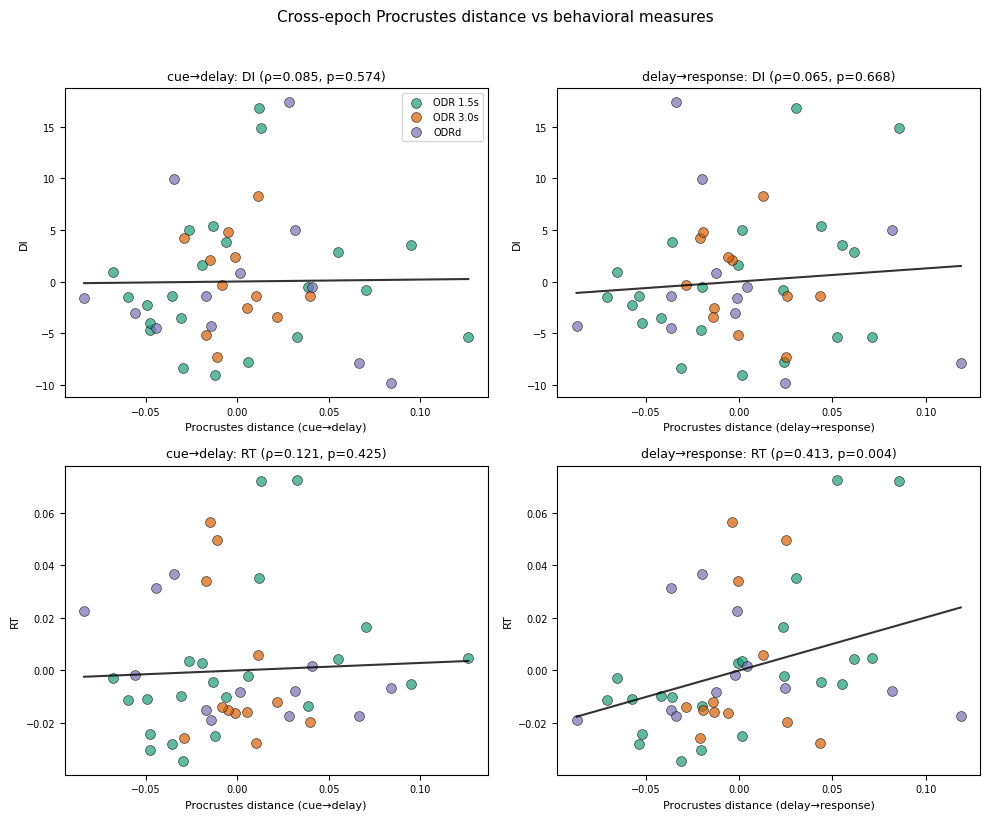

In [128]:
fig, axes = plt.subplots(2, 3, figsize=(14, 8))

for ci, (ea, eb) in enumerate(COMPARISONS):
    label = f'{ea}\u2192{eb}'

    for ri, beh_name in enumerate(['DI', 'RT']):
        ax = axes[ri, ci]
        all_d, all_beh = [], []

        for task_name in TASK_EPOCHS:
            rows = cross_epoch[task_name][label]
            if not rows:
                continue

            entries = [{'monkey': r['monkey'], 'group': r['group']} for r in rows]
            di_vals, rt_vals = get_behavioral_values(beh_df, entries, task_name, monkey_edges)
            beh_vals = di_vals if beh_name == 'DI' else rt_vals

            dists = np.array([r['distance'] for r in rows])
            valid = np.isfinite(beh_vals)

            ax.scatter(dists[valid] - np.mean(dists[valid]), beh_vals[valid] - np.mean(beh_vals[valid]),
                       c=TASK_COLORS[task_name], label=task_name,
                       s=50, alpha=0.7, edgecolors='k', linewidth=0.5)


            all_d.extend(dists[valid] - np.mean(dists[valid]))
            all_beh.extend(beh_vals[valid] - np.mean(beh_vals[valid]))

        # Pooled Spearman + regression line
        all_d   = np.array(all_d)
        all_beh = np.array(all_beh)
        if len(all_d) >= 3:
            rho, p = sts.spearmanr(all_d, all_beh)
            m, b = np.polyfit(all_d, all_beh, 1)
            x_line = np.linspace(all_d.min(), all_d.max(), 50)
            ax.plot(x_line, m * x_line + b, 'k-', lw=1.5, alpha=0.8)
            ax.set_title(f'{label}: {beh_name} (\u03c1={rho:.3f}, p={p:.3f})', fontsize=9)
            print(f'  Pooled {label} vs {beh_name}: '
                  f'\u03c1={rho:.3f}, p={p:.3f}, n={len(all_d)}')
        else:
            ax.set_title(f'{label}: {beh_name}', fontsize=9)

        ax.set_xlabel(f'Procrustes distance ({label})', fontsize=8)
        ax.set_ylabel(beh_name, fontsize=8)
        ax.tick_params(labelsize=7)
        if ri == 0 and ci == 0:
            ax.legend(fontsize=7)

fig.suptitle('Cross-epoch Procrustes distance vs behavioral measures',
             fontsize=11, y=1.02)
plt.tight_layout()